# Filtering And Selecting the Data

After taking time to understand the dataset and highlight all the challenges it poses in helping us answer the research question, we had a number of problems to overcome. 

In [86]:
#import necessary libraries 
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [87]:
#import data into dataframe 
#select the files you wish to put into the dataframe 
files = ["/Users/luffy_015/Desktop/Code/Group-3/Dashboard /2014.csv", "/Users/luffy_015/Desktop/Code/Group-3/Dashboard /2015.csv", "/Users/luffy_015/Desktop/Code/Group-3/Dashboard /2016.csv", "/Users/luffy_015/Desktop/Code/Group-3/Dashboard /2017.csv", "/Users/luffy_015/Desktop/Code/Group-3/Dashboard /2018.csv", "/Users/luffy_015/Desktop/Code/Group-3/Dashboard /2019.csv", "/Users/luffy_015/Desktop/Code/Group-3/Dashboard /2020.csv", "/Users/luffy_015/Desktop/Code/Group-3/Dashboard /2021.csv", "/Users/luffy_015/Desktop/Code/Group-3/Dashboard /2022.csv", "/Users/luffy_015/Desktop/Code/Group-3/Dashboard /2023.csv", "/Users/luffy_015/Desktop/Code/Group-3/Dashboard /2024.csv",] 
# Read and concatenate files while extracting the year from the filename
df = pd.concat([ 
    pd.read_csv(file).assign(year=int(os.path.basename(file).split('.')[0])) 
    for file in files
], ignore_index=True)

In [88]:
df.columns

Index(['@id', 'sample.samplingPoint', 'sample.samplingPoint.notation',
       'sample.samplingPoint.label', 'sample.sampleDateTime',
       'determinand.label', 'determinand.definition', 'determinand.notation',
       'resultQualifier.notation', 'result',
       'codedResultInterpretation.interpretation', 'determinand.unit.label',
       'sample.sampledMaterialType.label', 'sample.isComplianceSample',
       'sample.purpose.label', 'sample.samplingPoint.easting',
       'sample.samplingPoint.northing', 'year'],
      dtype='object')

In [89]:
#select necessary columns and rename them for interpretability 
df = df[['sample.isComplianceSample','sample.sampleDateTime', 'sample.samplingPoint.northing', 'sample.samplingPoint.easting', 'determinand.label', 'determinand.definition', 'result', 'determinand.unit.label', 'sample.sampledMaterialType.label', 'year']].copy()
df.columns = ['compliance','sample_date_time', 'northing', 'easting', 'determinand_label', 'determinand_def', 'result', 'determinand_unit','sample_type', 'year']

In [90]:
#change date time column to the appropriate dtype 
df['sample_date_time'] = pd.to_datetime(df['sample_date_time'])

In [91]:
df.head()

,compliance,sample_date_time,northing,easting,determinand_label,determinand_def,result,determinand_unit,sample_type,year
0,True,2014-01-15 10:48:00,233400,467020,NO FLOW/SAMP,No flow /No sample,0.00,coded,FINAL SEWAGE EFFLUENT,2014
1,True,2014-04-23 12:50:00,233400,467020,BOD ATU,BOD : 5 Day ATU,4.43,mg/l,FINAL SEWAGE EFFLUENT,2014
2,True,2014-04-23 12:50:00,233400,467020,Sld Sus@105C,"Solids, Suspended at 105 C",25.90,mg/l,FINAL SEWAGE EFFLUENT,2014
3,True,2014-04-23 12:50:00,233400,467020,Oil & Grs Vs,"Visible oil or grease, significant trace: Pres...",0.00,pres/nf,FINAL SEWAGE EFFLUENT,2014
4,True,2014-04-23 12:50:00,233400,467020,Ammonia(N),Ammoniacal Nitrogen as N,0.77,mg/l,FINAL SEWAGE EFFLUENT,2014


In [92]:
#determine the amount of unique water quality determinands measured 
df['determinand_label'].nunique()

1818

First of all, the dataset contains 1818 different 'determinand labels' which corresponds to a parameter being measured within the water to determine water wuality. Here comes out consideration of 'water quality' for the purpose of our project. It was unsuitable of us to consider all 1818 parameters for multiple reasons; first we do not have the resources or time to study each one and second not all 1818 parameters are measured at a significant number of sampling points so in comparisons it is likely we will run into problems if we analyse less frequently measured parameters. With the time available for this project we decided it was best if we pick 5 frequently occuring parameters to include in our analysis. This tailors our analysis toward specific measures of water quality and hence narrows the scope of our project. Now I will discuss how we decided upon the 5 parameters. 

In [93]:
#count the number of unique determinands to determine the best choice for analysis 
type_counts = df['determinand_label'].value_counts()
type_counts.head(10)

determinand_label
Ammonia(N)      899278
BOD ATU         865829
Temp Water      704635
Sld Sus@105C    696092
pH              595159
N Oxidised      527857
Nitrite-N       522015
Orthophospht    518280
O Diss %sat     516727
Nitrate-N       496962
Name: count, dtype: int64

This shows the top 10 most frequently occuring determinands in this dataset and choosing from this list gave us the best scope for comparison and the foundation for more reliable results due to a larger sample size. When choosing between these parameters we decided to visualise their trends over time to consider which would be the most interesting for investigation. 

In [94]:
#First some standard pre-processing 
#check for nulls 
print(df.isnull().sum())

compliance           0
sample_date_time     0
northing             0
easting              0
determinand_label    0
determinand_def      0
result               0
determinand_unit     0
sample_type          0
year                 0
dtype: int64


I will leave outliers for now as it is more suitable to remove outliers based on the sampling point types (which I will discuss more later) on a smaller scale to avoid normalising relevant entries. 

Now I will filter the dataframe to create a new dataframe for each of the top 10 most frequent determinands so we can compare them. 

We can see that each df contains the rows where the determinand label is the parameter correpsonding to that specific df. 

In [98]:
# Parameters you want to analyze
parameters = ['Ammonia(N)', 'BOD ATU', 'Nitrate-N', 'Sld Sus@105C', 'pH']

# Filter the dataset for just those parameters
filtered_df = df[df['determinand_label'].isin(parameters)]

# Group by year and determinand_label, then calculate the mean result
grouped = (
    filtered_df
    .groupby(['year', 'determinand_label'])['result']
    .mean()
    .reset_index()
    .pivot(index='year', columns='determinand_label', values='result')
)

# Now you can access each parameter's yearly mean like this:
print(grouped)


determinand_label  Ammonia(N)    BOD ATU  Nitrate-N  Sld Sus@105C        pH
year                                                                       
2014                 2.307315  52.678059   6.285034     54.303065  7.746174
2015                 2.827509  79.779602   6.469029     69.449237  7.771612
2016                 2.033183  58.450670   6.514252     56.562703  7.773500
2017                 2.393377  55.148493   7.431556     51.362515  7.753370
2018                 4.954380  55.259977   7.660097     50.506047  7.727449
2019                 1.872034  79.268373   6.386349     36.336242  7.822851
2020                 1.653739  49.258160   6.237771     39.473422  7.777643
2021                 2.539582  48.588050   5.355476     19.202338  7.819388
2022                 1.414821  51.075933   5.224040     26.924910  7.770779
2023                 1.363821  41.937881   5.243362     27.992678  7.746204
2024                 1.055600  33.367968   4.832929     27.943688  7.749202


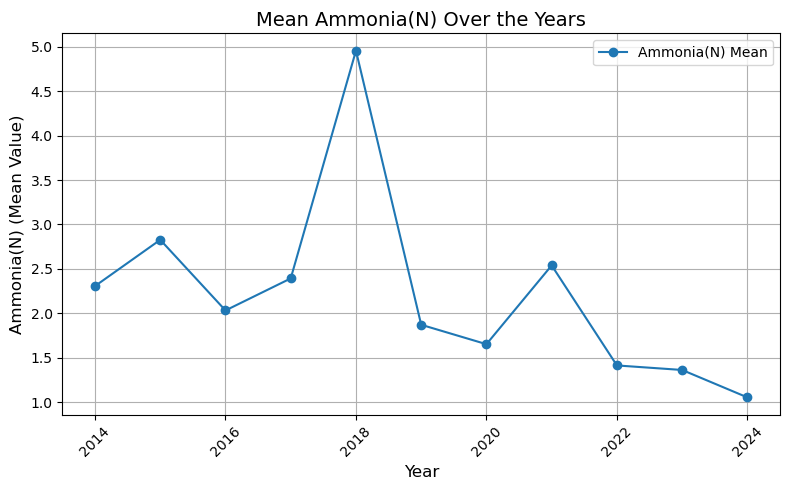

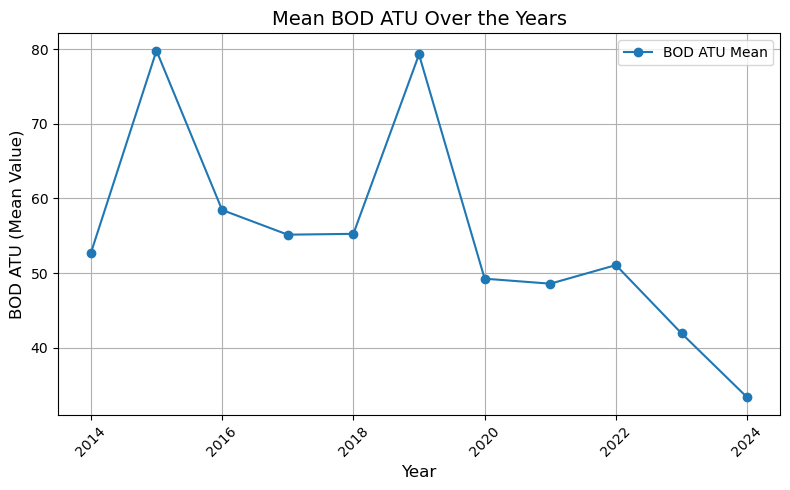

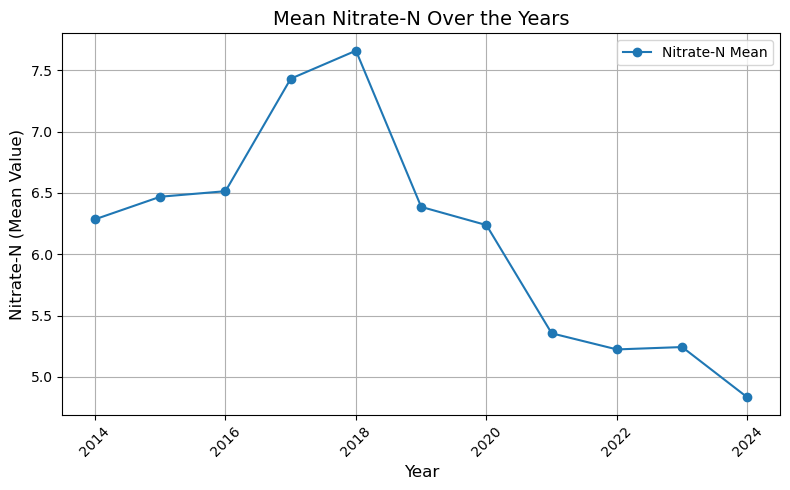

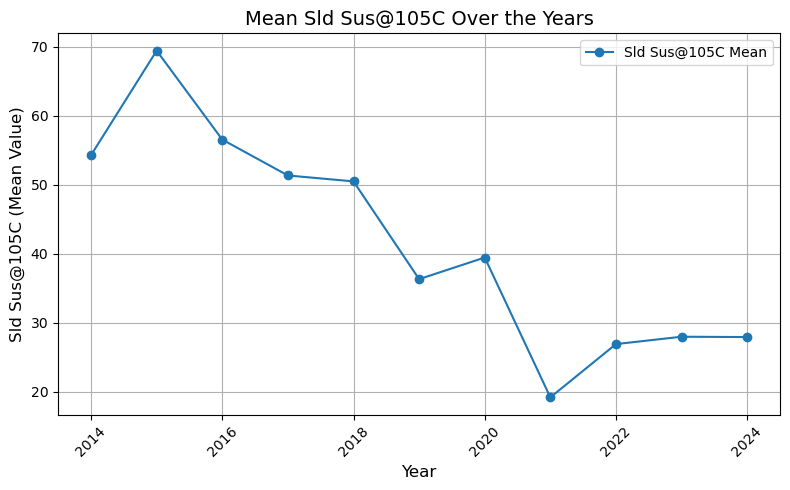

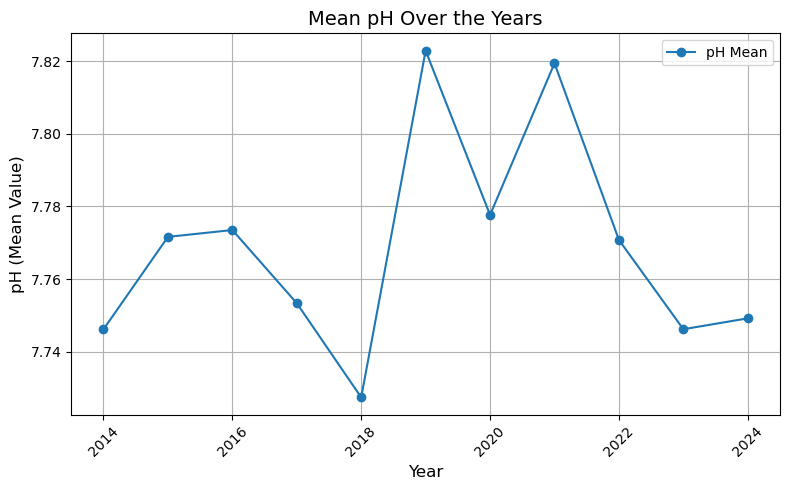

In [100]:
import matplotlib.pyplot as plt

# Loop through each parameter (i.e., column) in the pivoted DataFrame
for param in grouped.columns:
    plt.figure(figsize=(8, 5))

    # Plot year vs mean result
    plt.plot(grouped.index, grouped[param], marker='o', label=f'{param} Mean')

    # Formatting
    plt.title(f'Mean {param} Over the Years', fontsize=14)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(f'{param} (Mean Value)', fontsize=12)
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


For better comparison I will normalise the data so the differing unit scales do not interefere in an endeavor for better comparison and visualisation

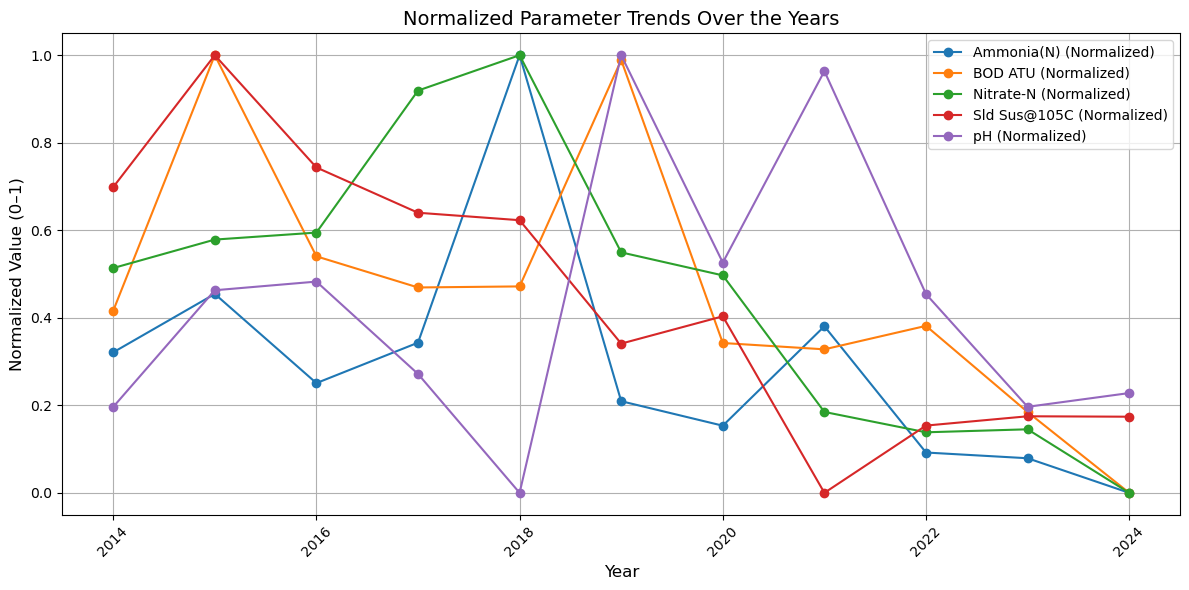

In [104]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Initialize scaler
scaler = MinMaxScaler()

plt.figure(figsize=(12, 6))

# Loop through each parameter (i.e., each column) in the grouped DataFrame
for param in grouped.columns:
    # Drop NA values (if any)
    series = grouped[param].dropna()

    # Normalize the series
    normalized_values = scaler.fit_transform(series.values.reshape(-1, 1)).flatten()

    # Plot normalized values
    plt.plot(series.index, normalized_values, marker='o', label=f'{param} (Normalized)')

# Plot settings
plt.title('Normalized Parameter Trends Over the Years', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Normalized Value (0–1)', fontsize=12)
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


We used these comparisons and background research to select our parameters for analysis. Note that these choices were ,at this stage, subject to change if more suitable choices were evident after ongoing analysis. The chosen parameters were as follows: 
1. Ammonia(N)
2. BOD ATU
3. pH
4. Sld Sus@105C
5. Nitrate-N

##ADD MORE INFO HERE ON SPECIFIC PARAMETER JUSTIFICATION INCLUDING RESEARCH EXTRERNAL TO THE DATASET

Now we can filter the dataset to consider only these parameters:

In [105]:
#select top 10 most frequent determinands to analyse
# Filter where 'determinand.label' is in ['Ammonia(N)', 'BOD ATU', 'Temp Water', 'Sld Sus@105C', 'pH', 'N Oxidised', 'Nitrite-N', 'Orthophospht', 'O Diss %sat', 'Nitrate-N']
filtered_df = df[df['determinand_label'].isin(['Ammonia(N)', 'BOD ATU', 'pH', 'Sld Sus@105C', 'Nitrate-N'])]

The second thing we were aware of was the large number of samples and sampling points. The sampling points are spread across a large number of sampling types which we deemed important to consider. This was because if we has considered all of them together and taken averages this would not have been truly representative of the water quality. For example, final sewage effluent which is sewage water after it has been treated will inevitably have different contaminants and different levels of contamination compared to groundwater or running surface water. It would be ideal to look at all types and draw comparisons however once again we do not have the time or resources so it's important we narrow the scope down to 1 type of water. 

In [106]:
#determine the amount of unique sample types measured 
filtered_df['sample_type'].nunique()

44

We can see that the dataset, once filtered eith our determinands, includes 44 different sampling types. This stood out as an important issue to address because different sample types will inevitably have differing water quality scores. For example, groundwater samples will naturally have more nutrients and minerals absorbed from the earth than a sample taken from a reservoir. To visualise the difference in the dataset between the main types we firstly found the most frequently occuring types in the dataset as it is important that we have an abundance of data to derive insights from.

In [107]:
#count the number of unique sample types to determine the best choice for analysis 
type_counts = filtered_df['sample_type'].value_counts()
type_counts.head(10)

sample_type
RIVER / RUNNING SURFACE WATER                      1647834
FINAL SEWAGE EFFLUENT                              1441906
CRUDE SEWAGE                                        148356
ANY TRADE EFFLUENT                                  101178
GROUNDWATER                                          77125
TRADE EFFLUENT - FRESHWATER RETURNED ABSTRACTED      35430
POND / LAKE / RESERVOIR WATER                        29381
GROUNDWATER - PURGED/PUMPED/REFILLED                 22936
ESTUARINE WATER                                       9463
SURFACE DRAINAGE                                      8841
Name: count, dtype: int64

From this we can see that the top 5 most frequently occuring types are 'RIVER/ RUNNING SURFACE WATER', 'FINAL SEWAGE EFFLUENT', 'CRUDE SEWAGE', 'ANY TRADE EFFLUENT' and 'GROUNDWATER'. To better compare these types we plotted a graph of the averages overtime. 

In [108]:
#split the dataframe to consider the top 5 types of sampling point 
df_running_water = df[df['sample_type'].isin(['RIVER / RUNNING SURFACE WATER'])].copy()
df_sewage_final = df[df['sample_type'].isin(['FINAL SEWAGE EFFLUENT'])].copy()
df_sewage_crude = df[df['sample_type'].isin(['CRUDE SEWAGE'])].copy()
df_trade = df[df['sample_type'].isin(['ANY TRADE EFFLUENT'])].copy()
df_groundwater = df[df['sample_type'].isin(['GROUNDWATER'])].copy()

#group the data to get an average 
df_running_water_grouped = df_running_water.groupby('year')['result'].mean()
df_sewage_final_grouped = df_sewage_final.groupby('year')['result'].mean()
df_sewage_crude_grouped = df_sewage_crude.groupby('year')['result'].mean()
df_trade_grouped = df_trade.groupby('year')['result'].mean()
df_groundwater_grouped = df_groundwater.groupby('year')['result'].mean()

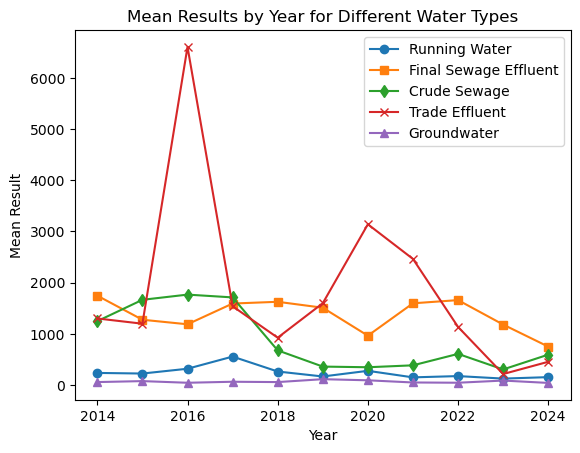

In [109]:
plt.plot(df_running_water_grouped.index, df_running_water_grouped, label='Running Water', marker='o')
plt.plot(df_sewage_final_grouped.index, df_sewage_final_grouped, label='Final Sewage Effluent', marker='s')
plt.plot(df_sewage_crude_grouped.index, df_sewage_crude_grouped, label='Crude Sewage', marker='d')
plt.plot(df_trade_grouped.index, df_trade_grouped, label='Trade Effluent', marker='x')
plt.plot(df_groundwater_grouped.index, df_groundwater_grouped, label='Groundwater', marker='^')

plt.xlabel('Year')
plt.ylabel('Mean Result')
plt.title('Mean Results by Year for Different Water Types')
plt.legend()

plt.show()

Now I will normalise the data for better comparison. 

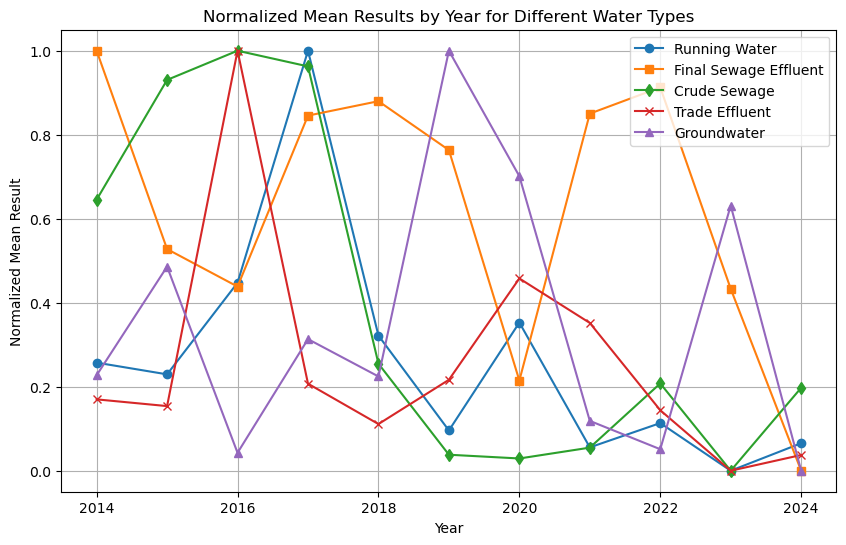

In [110]:
# combine into a DataFrame for normalisation
df_combined = pd.DataFrame({
    'Running Water': df_running_water_grouped,
    'Final Sewage Effluent': df_sewage_final_grouped,
    'Crude Sewage': df_sewage_crude_grouped,
    'Trade Effluent': df_trade_grouped, 
    'Groundwater': df_groundwater_grouped,
})

# normalise
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df_combined), 
                             columns=df_combined.columns, 
                             index=df_combined.index)
# plot the normalised data
plt.figure(figsize=(10, 6))
plt.plot(df_normalized.index, df_normalized['Running Water'], label='Running Water', marker='o')
plt.plot(df_normalized.index, df_normalized['Final Sewage Effluent'], label='Final Sewage Effluent', marker='s')
plt.plot(df_normalized.index, df_normalized['Crude Sewage'], label='Crude Sewage', marker='d')
plt.plot(df_normalized.index, df_normalized['Trade Effluent'], label='Trade Effluent', marker='x')
plt.plot(df_normalized.index, df_normalized['Groundwater'], label='Groundwater', marker='^')

plt.xlabel('Year')
plt.ylabel('Normalized Mean Result')
plt.title('Normalized Mean Results by Year for Different Water Types')
plt.legend()
plt.grid(True)

plt.show()

This analysis does not offer much help in choosing the type for our analysis as all of them seem to have interesting and investigativable trends over time so we had to do further research to help narrow the scope here. Running water is a strong contender and was our final choice due to it's compatibility with our chosen parameters. In terms of agriculture sediment and soil erosion from plowing and deforestation increase the sediment pollution, fertilizer runoff can cause nitrogen contamination, pesticides can get washed into rivers during heavy rainfall and livestock waste can pollute surface water with ammonia. This covers all bases of our chosen determinands. We eliminated the others due to less suitability. 

Now we can filter the dataset to only contain RIVER / RUNNING SURFACE WATER data. 

In [111]:
#filter out the other types and keping the River/ Running Surface Water
df_filtered = filtered_df[filtered_df['sample_type'].isin(['RIVER / RUNNING SURFACE WATER'])].copy()

In [112]:
df_filtered.head()

,compliance,sample_date_time,northing,easting,determinand_label,determinand_def,result,determinand_unit,sample_type,year
44,False,2014-01-20 12:29:00,241400,463800,Sld Sus@105C,"Solids, Suspended at 105 C",16.800,mg/l,RIVER / RUNNING SURFACE WATER,2014
47,False,2014-01-20 12:29:00,241400,463800,pH,pH,8.000,phunits,RIVER / RUNNING SURFACE WATER,2014
51,False,2014-01-20 12:29:00,241400,463800,Ammonia(N),Ammoniacal Nitrogen as N,0.036,mg/l,RIVER / RUNNING SURFACE WATER,2014
56,False,2014-01-20 12:29:00,241400,463800,Nitrate-N,Nitrate as N,4.270,mg/l,RIVER / RUNNING SURFACE WATER,2014
59,False,2014-02-12 11:22:00,241400,463800,Sld Sus@105C,"Solids, Suspended at 105 C",25.600,mg/l,RIVER / RUNNING SURFACE WATER,2014


Now the dataset has been filtered and selected carefully and appropriately for the purpose of our project and we can proceed with analysis and EDA. 

In [113]:
df_filtered.shape

(1647834, 10)

In [114]:
df_filtered.dtypes

compliance                     bool
sample_date_time     datetime64[ns]
northing                      int64
easting                       int64
determinand_label            object
determinand_def              object
result                      float64
determinand_unit             object
sample_type                  object
year                          int64
dtype: object

In [115]:
df_water = df_filtered[df_filtered["compliance"] == False]

In [116]:
df_water.to_csv('Water Data Pre-processed.csv')

In [117]:
from IPython.display import FileLink
FileLink("Water Data Pre-processed.csv")

/Users/luffy_015/Desktop/Code/Group-3/Water Data Pre-processed.csv